# Acoustic modelling with Devito (distributed across shots with Ray)

This notebook showcases how to perform 2D acoustic modelling Devito. Ray is used to parallelize the computations across shots.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import devito
import ray 

from scipy.interpolate import RegularGridInterpolator
from examples.seismic import Model, RickerSource

from devitomod.acoustic.ac2d import Acoustic2D

os.environ["RAY_DEDUP_LOGS"] = '0'
devito.configuration['log-level'] = 'ERROR'

In [2]:
# Initialize ray
ray.init(num_cpus=4, include_dashboard=False)

2024-05-28 20:57:13,063	INFO worker.py:1621 -- Started a local Ray instance.


Python version:,3.11.9
Ray version:,2.6.3


## Velocity model

In [3]:
# Load model
f = np.load('../data/SeamPhase1.npz')

vp = f['vp']
x, z = f['x'], f['z']
nx, nz = len(x), len(z)
dx, dz = x[1] - x[0], z[1] - z[0]

## Modelling parameters

In [4]:
# velocity model parameter
shape = (nx, nz)
spacing = (dx, dz)
origin = (0, 0)

# source and receiver geometry
nsrc = 8
nrec = nx
osrc = x[-1]//4

# other modelling params
nbl = 150 # Number of boundary layers around the domain
space_order = 6 # Space order of the simulation
f0 = 10 # Source peak frequency (Hz)
fs = True
fslabel = '_fs' if fs else ''

t0 = 0. # Initial time
tmax = 5000 # Total simulation time (ms)
dt = 4 # Time sampling of observed data (ms)

## Modelling

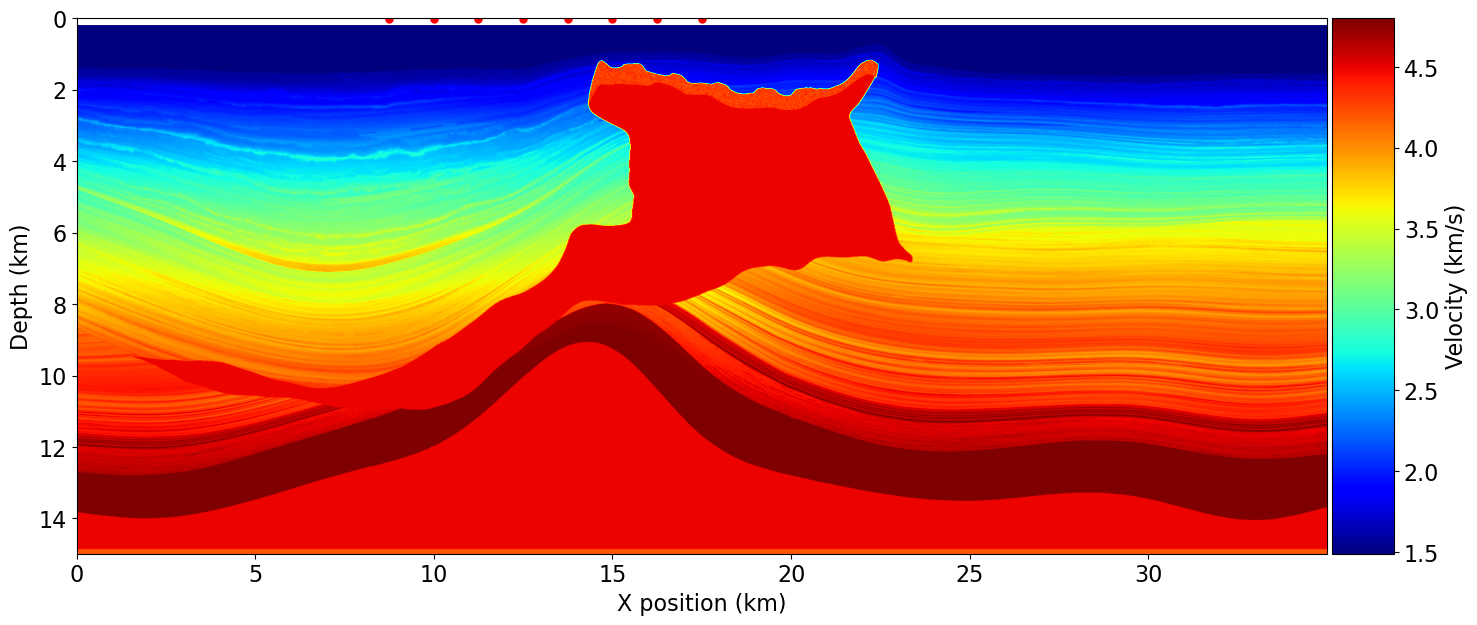

In [5]:
awe = Acoustic2D()

awe.create_model(shape, origin, spacing, vp.T, space_order, nbl=nbl, fs=fs)
awe.create_geometry(src_x=np.arange(0, nsrc) * spacing[0] * 100 + osrc,
                    src_z=20,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=20,
                    t0=t0, tn=tmax, src_type='Ricker', f0=f0)

awe.plot_velocity(figsize=(17, 9))

### Model multiple shots in parallel

In [6]:
dtot, taxis = awe.ray_solve_all_shots()

(_ray_solve_one_shot pid=44394) Operator `Forward` ran in 41.94 s
(_ray_solve_one_shot pid=44394) Operator `Forward` ran in 40.08 s [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


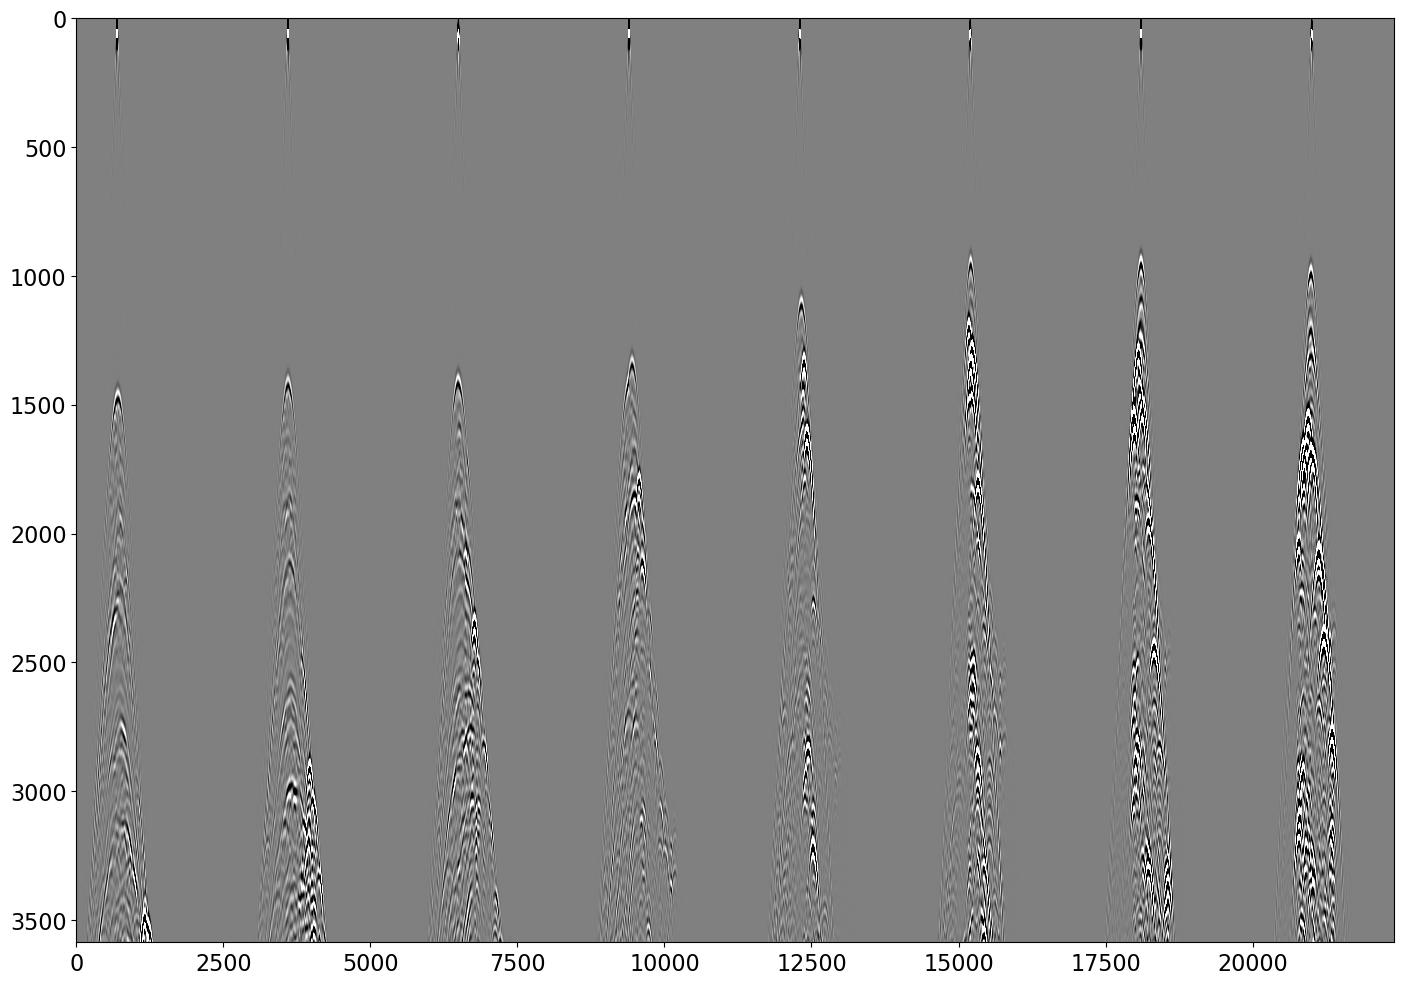

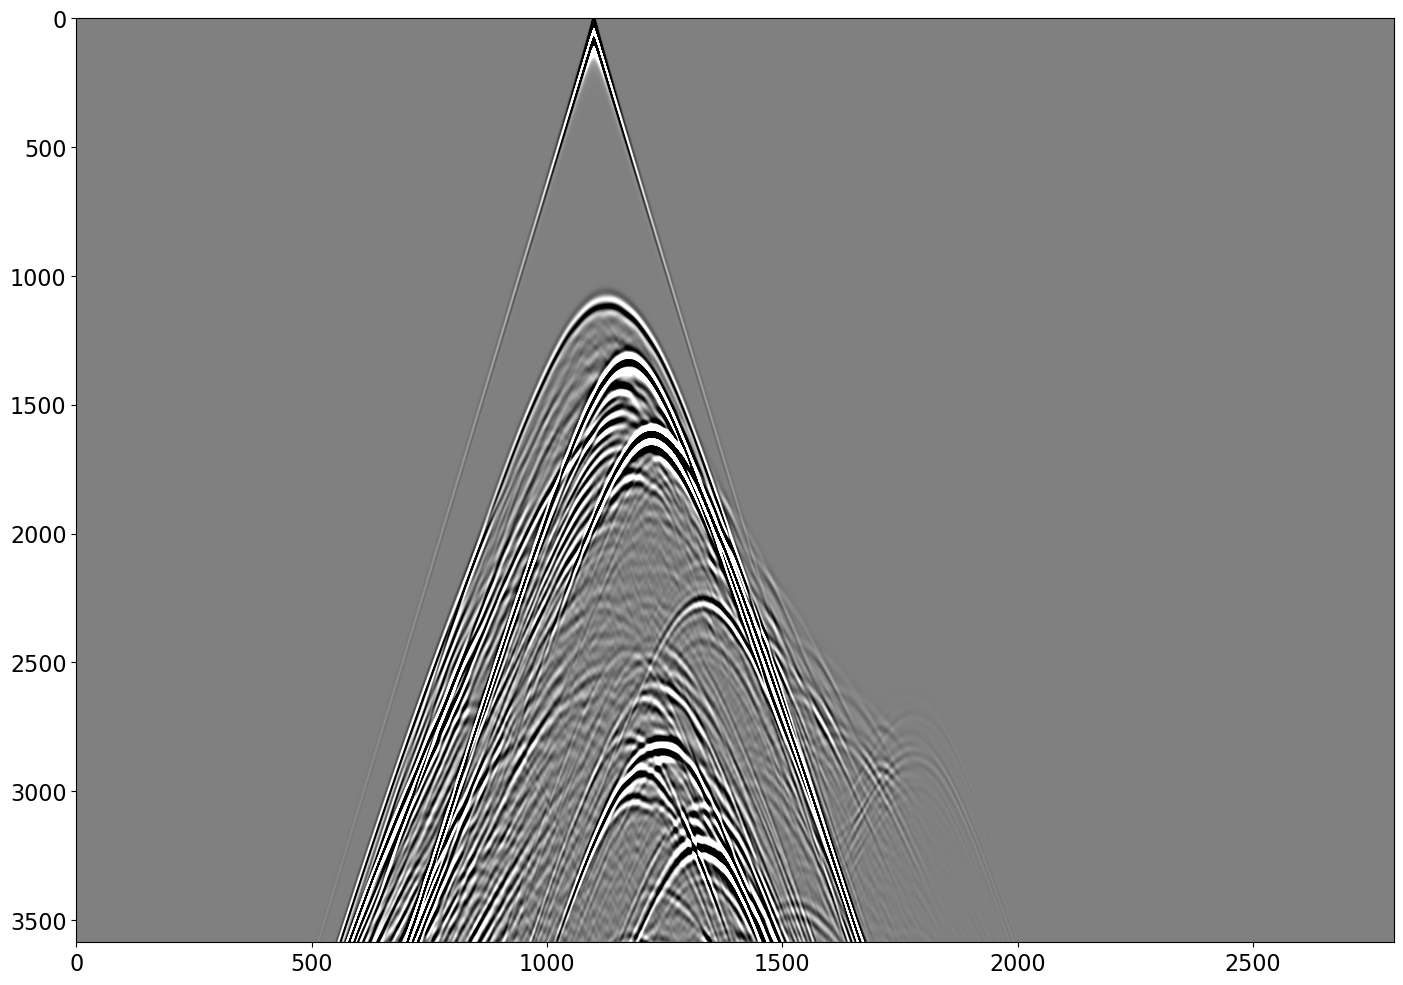

In [9]:
# Cutting data to wavelet center and visualize
wav = awe.geometry.src.resample(dt).data[:, 0]
wavc = np.argmax(wav)

plt.figure(figsize=(17, 12))
plt.imshow(dtot.reshape(nrec*nsrc, -1)[:, wavc:].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
plt.axis('tight')

plt.figure(figsize=(17, 12))
plt.imshow(dtot[nsrc//2][:, wavc:].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
plt.axis('tight');